# Text Analysis - Finding Themes and Patterns
## Pt 3 - Clustering on Features and Vectors

In some instances it may be preferable to use another approach to finding themes in text. If you have particularly homgenous data, i.e. a lot of text all around the same broad topic, it may be difficult for LDA to distinguish out themes. These other approaches may allow you to draw out themes when LDA can't.

In [16]:
import pandas as pd
import spacy
import gensim

# For later plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
# FUNCTIONS
def train_phraser(texts, stopwords):
    sentences = [
        [token.lemma_.lower() for token in sentence if token.lemma_.lower().isalpha()]
        for doc in texts 
        for sentence in doc.sents]
    
    bigram_phraser = gensim.models.Phrases(sentences, common_terms=stopwords)
    return bigram_phraser


def filter_text(spacy_doc, phraser, stopwords):
    transformed_doc = []
    for sentence in spacy_doc.sents:
        sentence_tokens = [token.lemma_.lower() for token in sentence if token.lemma_.lower().isalpha()]
        transformed = phraser[sentence_tokens]
        transformed_doc.extend(transformed)
    tokens = [token for token in transformed_doc if token.lower() not in stopwords]
    return tokens

def dummy_function(doc):
    return doc

def top_terms(df, group_name=None, top_n=5):
    if group_name is not None:
        df = df.drop(columns=[group_name])
        
    return df.sum().sort_values(ascending=False).head(top_n)

## Setup 
Run all the cells from here to "SETUP END!" to load, and preprocess our data. You can do this quickly by clicking to the left of this cell to select it, holding shift and then clicking to select the cell "SETUP END!". This should highlight all cells in between, then just click the run button. Whilst you're waiting for it to run have a read of the intro to the next section.

### 1. Loading our Sample Data
See part 1 for full details on this process

In [18]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_to_fetch = ['alt.atheism', 'talk.religion.misc','comp.graphics', 'sci.space']

news_set = fetch_20newsgroups(subset='all', 
                              categories=newsgroups_to_fetch,
                              remove=('headers', 'footers', 'quotes'))

In [19]:
df = pd.DataFrame({'text':news_set['data'], 'category_num':news_set['target']})

In [20]:
category_lookup = {position: item for position, item in enumerate(news_set['target_names'])}
category_lookup

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'sci.space', 3: 'talk.religion.misc'}

In [21]:
df['category_label'] = df['category_num'].apply(lambda category_number: category_lookup[category_number])

In [22]:
df.head()

,text,category_num,category_label
0,My point is that you set up your views as the ...,0,alt.atheism
1,\nBy '8 grey level images' you mean 8 items of...,1,comp.graphics
2,FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n ...,1,comp.graphics
3,"I responded to Jim's other articles today, but...",3,talk.religion.misc
4,"\nWell, I am placing a file at my ftp today th...",1,comp.graphics


### 2. Preparing our Text

In [23]:
nlp = spacy.load('en_core_web_md')

In [24]:
stop_list = nlp.Defaults.stop_words


In [25]:
%time df['text_nlp'] = list(nlp.pipe(df['text'],n_process=7))

CPU times: user 13.3 s, sys: 1.39 s, total: 14.7 s
Wall time: 56.5 s


In [26]:
phraser = train_phraser(df['text_nlp'], stopwords=stop_list)

In [27]:
df['cleaned_tokens'] = df['text_nlp'].apply(filter_text, stopwords=stop_list, phraser=phraser)

In [28]:
df['cleaned_tokens']

0       [point, set, view, way, believe, eveil, world,...
1       [grey, level, image, mean, item, image, work, ...
2       [annual, phigs, user, group, conference, annua...
3       [respond, jim, article, today, neglect, respon...
4       [place, file, ftp, today, contain, polygonal, ...
                              ...                        
3382    [work, program, display, wireframe, model, use...
3383    [russian, ill, fate, phobos, mission, year_ago...
3384    [oh, gee, billion, dollar, cover, cost, feasab...
3385    [look, software, run, brand_new, know, site, u...
3386    [month, look, job, computer_graphic, software,...
Name: cleaned_tokens, Length: 3387, dtype: object

## Vectorizing

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [179]:
tfidf_vec = TfidfVectorizer(tokenizer=dummy_function,
                            preprocessor=dummy_function,
                            min_df=0.01, max_df=0.999)

In [180]:
tfidf_matrix = tfidf_vec.fit_transform(df['cleaned_tokens'])

In [181]:
tfidf_matrix.shape # let's remind ourselves - the matrix is currently 3,387 documents to 20,236 terms, or dimensions.

(3387, 1092)

<a id='dimensionality'></a>


## Reduce the Dimensionality of the Data

**FIRST scroll down and run the cells up to 'Visualizing Clusters', then come back and have a read**

What do we mean by reduce the dimensionality? Imagine a simple line graph with an x-axis and a y-axis. These two dimensions allow us not only to see a relationship between changes in the x value and the y value, but also that some points are more similar than others because they are close to one another in 2-dimensional space.

<img src="https://github.com/Minyall/sc207_materials/blob/master/images/scatterPlot.png?raw=true" width="400">

If we had another dimension - age for example - that would be a three-dimensional plot as the values will have to be plotted in relation to each other in three different directions.
<img src="https://github.com/Minyall/sc207_materials/blob/master/images/3dscatterplotrotateanim.gif?raw=true" width="400" align="right">





Our news data has 3,387 samples, or points to plot, and 20,236 dimensions i.e. they would need to be arranged in a 20,236 dimensional space to find their relation to one another. Whilst some of the clustering algorithms are capable of working with high dimensional data, in text data, high dimensionality is often noisier and harder to find clear patterns in. 

We need to get our dimensionality back to two. To do this we use a variety of 'Principal Component Analysis' (PCA) which reduces the amount of data in the dataset to fewer dimensions. These fewer dimensions no longer directly represent the measured values, but still represent the variation that those original values expressed.

For more on PCA and some explainers see http://setosa.io/ev/principal-component-analysis/

Whilst PCA is a good all round method, for 'sparse' data like our document / term matrices Scikit recommend using [Truncated SVD](http://scikit-learn.org/stable/modules/decomposition.html#lsa) to reduce the dimensions to around 50.

We can then use [t-distributed Stochastic Neigbour Embedding (TSNE)](http://scikit-learn.org/stable/modules/manifold.html#t-sne) which specialises in dimensionality reduction for visualising high dimensional data down to two or three dimensions. TSNE is highly 'expensive' in terms of processing time compared to PCA, but provides more accurate results for clustering and visualising.

- Google has an accessible Tech Talk on TSNE on [YouTube](https://youtu.be/RJVL80Gg3lA)

- A very useful visual site on understanding the variables and options in TSNE and their impact...
https://distill.pub/2016/misread-tsne/

- A good FAQ on TSNE from its developer https://lvdmaaten.github.io/tsne/

In [ ]:
from sklearn.pipeline import make_pipeline # used to link together a series of transformations into a single operator.
from sklearn.decomposition import TruncatedSVD # our dimensionality reduction technique
from sklearn.manifold import TSNE

In [157]:
%time reduced_news_matrix = dimension_reducer.fit_transform(vectors) # 1 min 27s on Mac Pro

/Users/James/anaconda3/envs/teaching/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/envs/teaching/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/James/anaconda3/envs/teaching/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

CPU times: user 23.1 s, sys: 519 ms, total: 23.6 s
Wall time: 21.8 s


In [158]:
reduced_news_matrix.shape # now we can see we have the same amount of documents, 
# but the extent of their variation based on their terms is now repesented as two dimensions

(18846, 2)

<a id='plot'></a>


## Visualising Clusters
Whilst Pandas is good for visualising data, the [Seaborn](https://seaborn.pydata.org) package provides high quality visualisations with very little effort, and is built to integrate with Pandas.

In [159]:
import seaborn as sns # sns is the conventional shortening for seaborn
%matplotlib inline 
# Jupyter magic to show plots in the notebook

In [160]:
# first let's put our reduced array into Pandas for ease of integration with seaborn

reduc_values = pd.DataFrame(reduced_news_matrix, columns=['x','y'])
reduc_values.head(3) # show just top 3 records for brevity

,x,y
0,-1.321321,-4.239858
1,2.299153,2.551402
2,3.431734,5.815783


In [161]:
# and we can add the x and y columns to our original data...
data = df.join(reduc_values)
data.head()

,text,category_num,category_label,text_nlp,cleaned_tokens,x,y
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"(\n\n, I, am, sure, some, bashers, of, Pens, f...","[sure, basher, pens, fan, pretty, confused, la...",-1.321321,-4.239858
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"(My, brother, is, in, the, market, for, a, hig...","[brother, market, high_performance, video_card...",2.299153,2.551402
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"(\n\n\n\n\t, Finally, you, said, what, you, dr...","[finally, dream, mediterranean, new, area, gre...",3.431734,5.815783
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"(\n, Think, !, \n\n, It, 's, the, SCSI, card, ...","[think, scsi_card, dma, transfer, disk, scsi_c...",2.867868,-0.710625
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"(1, ), , I, have, an, old, Jasmine, drive, ...","[old, jasmine, drive, use, new, system, unders...",2.327399,-0.007251


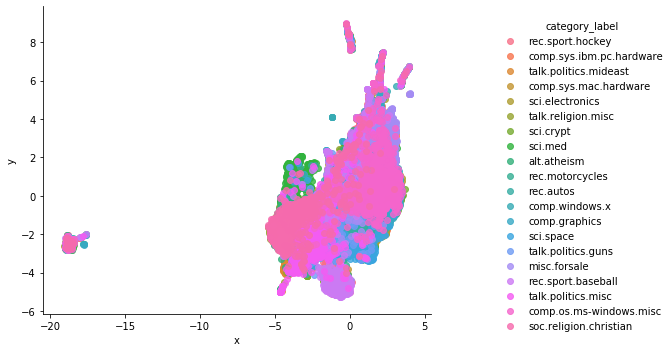

In [162]:
# we can now plot this into a scatter plot.

graph = sns.lmplot(data=data, x='x', y='y',fit_reg=False, hue='category_label')
graph.fig.set_size_inches(10,5)

In [163]:
import datashader as ds
import datashader.transfer_functions as tf
# from holoviews.operation.datashader import datashade
# from holoviews.operation import decimate

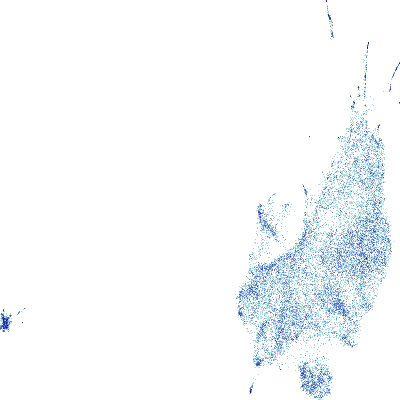

In [164]:
canvas = ds.Canvas(plot_width=400, plot_height=400)

tf.shade(canvas.points(data, x='x', y='y', agg=ds.count()), how='log')


In [ ]:
# if we use the 'hue' parameter, we can colour our nodes depending on which newsgroup the document is from,
# providing us a good sense of how well the algorithms have done in grouping similar documents together.

graph = sns.lmplot(data=data, x='x', y='y',fit_reg=False, hue='category_label')
graph.fig.set_size_inches(10,5)

There is a clear clustering of topics together, with 'space' and 'comp.graphics' topics seperating fairly nicely. Interestingly where there is not seperation is between alt.atheism and misc. religious talk. This in a way is reassuring, because it has not clustered arbitarily, but recognises similarity in the the discussions occuring in the seperate groups. This is interesting as it suggests a structure that is not necessarily reflected by the categorisation we have. We also have clusters of text that seem to be distinct from their parent groupings.

It is worth considering the caveats of TSNE.
- The distance between points indicates trhe probability of association rather than a clear distance measure, meaning measuring the distance between points is not necessarily useful.
- It is predominantly a technique for visualising data, but not necessarily one for fine-grained analysis.
- It is more like a form of 'computer intuition' as it attempts to provide a representation of the data that preserves its global and local structure.

The original paper is [available here](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)

<a id='clustering'></a>


## Finding Themes and Clusters without Labels
There are a variety of techniques for clustering and categorising data and drawing out themes or structures when you do not have pre-exisitng labels. 

We're going to look at two methods...
- [K-Means Clustering](http://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans)
- [Latent Dirichlet Allocation](http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) (Topic Modelling)

<a id='kmeans'></a>


### K-Means
Stanford have a useful [interactive visualisation](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html) of K-Means.

It is a relatively simple 'partitioning' algorithm that can still have good results, especially if paired with strong dimensionality reduction techniques. Kmeans utilises the spatial distance between points to determine how similar they are, and then demarcates boundaries. This is why it is better understood as a partitioning algorithm, rather than clustering, as all documents must be assigned a cluster - no matter how distant they are. 

In [ ]:
from sklearn.cluster import MiniBatchKMeans 
# Sklearn has a Kmeans import but Minibatch is more robust
# and deals better with large datasets.

In [ ]:
km = MiniBatchKMeans(verbose=0, # as with TSNE
                    init='k-means++',# original kmeans is very sensitive to the initial placement of the centroids. ++ adjusts for this.
                    n_clusters=3) # the key issue with k-means is that you must manually choose how many clusters it will find.
                    # we'll choose 4 because we know that's how many categories we have

In [ ]:
km.fit(data[['x','y']]) # we fit to our original 2 dimensional array

In [ ]:
# now we have cluster labels for each of our documents...
print(km.labels_)
print(km.labels_.shape)

In [ ]:
# we can add these to our existing data...
data['k_labels'] = km.labels_
data.head()

In [ ]:
hdb = HDBSCAN(min_cluster_size=60, cluster_selection_method='leaf')

In [ ]:
hdb.fit(data[['x','y']])

In [ ]:
data['hdb_labels'] = hdb.labels_

In [ ]:
# now if we plot our values as before, we;ll have the same distribution of plot points because we're using the same
# x and y, but our colouring will be based on the K labels instead...


graph = sns.lmplot(data=data, x='x', y='y',fit_reg=False, hue='k_labels')
graph.fig.set_size_inches(10,5)

In [ ]:
plot_data = data[data['hdb_labels'] != -1]

In [ ]:

graph = sns.lmplot(data=plot_data, x='x', y='y',fit_reg=False, hue='hdb_labels')
graph.fig.set_size_inches(10,5)

In [ ]:
k_vs_labels = data.pivot_table(columns=['k_labels'],index = 'category_label',values='text', aggfunc='count')
k_vs_labels


In [ ]:
sns.heatmap(k_vs_labels, cmap='Greens', linewidths=1) # cmap is colour map, for a full list

In [ ]:
hdb_vs_labels = data.pivot_table(columns=['hdb_labels'],index = 'category_label',values='text', aggfunc='count')
hdb_vs_labels

In [ ]:
sns.heatmap(hdb_vs_labels.drop(columns=[-1]), cmap='Greens', linewidths=1) # cmap is colour map, for a full list

In [ ]:
# if we compare with the actual labels
graph = sns.lmplot(data=data, x='x', y='y',fit_reg=False, hue='category_label')
graph.fig.set_size_inches(10,5)

#### Determining an appropriate K value
If we have no idea of how many topics or clusters are in our data one way to try to find it is using an elbow plot. An elbow plot runs multiple clustering exercises with a different number of clusters. For each run we can extract the sum of the squared distance from their closest cluster centre, for all points. Adding additional centroids to cluster  around will initially reduce this number dramatically, but eventually we get to a point where adding another cluster makes negligble difference. This is our elbow, and provides an indication of how many clusters we should aim for.

In [ ]:
def elbow_plot(data,maxK=10):
    elbow_data = {}
    for k in range(1, maxK+1):
        kmeans = MiniBatchKMeans(n_clusters=k,
                                 max_iter=100,
                                 n_init=50,
                                 random_state=0).fit(data)
        elbow_data[k] = kmeans.inertia_
    pd.DataFrame.from_dict([elbow_data]).transpose().plot()
    return 

In [ ]:
elbow_plot(data[['x','y']],maxK=10)

The elbow often provides more of a range than a definitive elbow, here between 3 and 5. If we go back at reset our k to a different figure we can compare to the known labels. However without labels the next best step is to look at the text itself.

#### Significant Terms by Cluster

In [ ]:
k_clustered_scores = pd.concat([data['k_labels'],tfidf_df.drop(columns=['category_label'])], axis=1)

In [ ]:
def top_terms(df, cluster_col, top_n=5):
    return df.drop(columns=[cluster_col]).sum().sort_values(ascending=False).head(top_n)

In [ ]:
k_clustered_scores.groupby('k_labels').apply(top_terms, 'k_labels')

# Finding Clusters in Unlabelled Data

In [ ]:
news_data = pd.read_pickle('news_data.pkl')
news_data['query'].value_counts()

In [ ]:
news_data = news_data[news_data['query'] == 'billionaire'].copy().reset_index(drop=True)
news_data.head()

In [ ]:
news_data['text_nlp'] = list(nlp.pipe(news_data['text'], n_process=7))

In [ ]:
news_data['cleaned_text'] = news_data['text_nlp'].apply(filter_text)

In [ ]:
news_texts = news_data['cleaned_text'].apply(' '.join)

In [ ]:
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.99)
news_matrix = tfidf.fit_transform(news_texts)

In [ ]:
term_scores = pd.DataFrame(news_matrix.toarray(), columns=tfidf.get_feature_names())

In [ ]:
reduced = dimension_reducer.fit_transform(news_matrix)

In [ ]:
reduced_df = pd.DataFrame(reduced,columns=['x','y'])

In [ ]:
news_data = pd.concat([news_data, reduced_df], axis=1)


In [ ]:
news_data.head()

In [ ]:
elbow_plot(news_data[['x','y']])

In [ ]:
km = MiniBatchKMeans(verbose=1, # as with TSNE
                    init='k-means++',# original kmeans is very sensitive to the initial placement of the centroids. ++ adjusts for this.
                    n_clusters=3)

In [ ]:
km.fit(news_data[['x','y']])

In [ ]:
news_data['k_labels'] = km.labels_

In [ ]:
graph = sns.lmplot(data=news_data, x='x', y='y',fit_reg=False, hue='k_labels')
graph.fig.set_size_inches(10,5)

In [ ]:
term_scores = pd.DataFrame(news_matrix.toarray(), columns=tfidf.get_feature_names())
term_scores = pd.concat([news_data['k_labels'], term_scores], axis=1)

In [ ]:
term_scores.groupby('k_labels').apply(top_terms, cluster_col='k_labels', top_n=10)

In [ ]:
k = 0

for i, row in news_data[news_data['k_labels'] == k].sample(10).iterrows():
    print(row['thread.title_full'])

# Working with Semantic Vectors

In [ ]:
one_doc = news_data.loc[0,'text_nlp']

In [ ]:
vectors = news_data['text_nlp'].apply(lambda doc: pd.Series(doc.vector))

In [ ]:
reduced_vectors = dimension_reducer.fit_transform(vectors)

In [ ]:
reduc_values = pd.DataFrame(reduced_vectors, columns=['vec_x','vec_y'])
news_data = news_data.join(reduc_values)

In [ ]:
graph = sns.lmplot(data=news_data, x='vec_x', y='vec_y',fit_reg=False)
graph.fig.set_size_inches(10,5)

In [ ]:
elbow_plot(news_data[['vec_x','vec_y']])

In [ ]:
km = MiniBatchKMeans(verbose=0, # as with TSNE
                    init='k-means++',# original kmeans is very sensitive to the initial placement of the centroids. ++ adjusts for this.
                    n_clusters=3)

In [ ]:
km.fit(news_data[['vec_x','vec_y']])

In [ ]:
news_data['k_labels'] = km.labels_

In [ ]:
graph = sns.lmplot(data=news_data, x='vec_x', y='vec_y',fit_reg=False, hue='k_labels')
graph.fig.set_size_inches(10,5)

In [ ]:
k = 1

for i, row in news_data[news_data['k_labels'] == k].sample(10).iterrows():
    print(row['thread.title_full'])

In [ ]:
k_vs_labels = news_data.pivot_table(columns=['k_labels'],index = 'query',values='text', aggfunc='count')
k_vs_labels


In [ ]:
sns.heatmap(k_vs_labels, cmap='Greens', linewidths=1) # cmap is colour map, for a full list

In [ ]:
from hdbscan import HDBSCAN

In [ ]:
clusterer = HDBSCAN(cluster_selection_method='leaf', min_cluster_size=30)

In [ ]:
clusterer.fit(df[['x','y']])

In [ ]:
df['hdb_labels'] = clusterer.labels_

In [ ]:
graph = sns.lmplot(data=df, x='x', y='y',fit_reg=False, hue='hdb_labels')
graph.fig.set_size_inches(10,5)

In [ ]:
k_vs_labels = df.pivot_table(columns=['hdb_labels'],index = 'category_label',values='text', aggfunc='count')
k_vs_labels

In [ ]:
sns.heatmap(k_vs_labels.drop(columns=[-1]), cmap='Greens', linewidths=1) # cmap is colour map, for a full list

## Bonus! Non-negative matrix factorization (NMF)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
nmf = NMF(n_components=20, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(news_matrix)

In [ ]:
term_topic_matrix = nmf.components_
doc_topic_matrix = nmf.transform(news_matrix)